In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf

In [83]:
temperature

Temp
Date            
1996-01-01  27.0
1996-01-02  27.2
1996-01-03  27.2
1996-01-04  27.2
1996-01-05  27.1
...          ...
2018-07-22  28.5
1970-05-04  28.5
2018-07-30  28.7
2018-07-31  28.7
2018-08-01  28.7

[8103 rows x 1 columns]

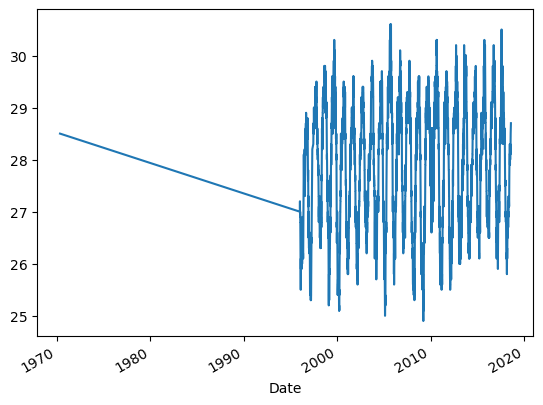

In [68]:
temperature = pd.read_csv('new_temp.csv')
temperature['Date'] = pd.to_datetime(temperature['Date'])
temperature.set_index('Date', inplace=True)
temperature['Temp'].values
temperature = temperature.convert_dtypes(convert_floating=True)
temperature['Temp'] = temperature['Temp'].replace('nd', pd.NA).astype(float)
nan_rows = temperature[temperature['Temp'].isna()].index

# Forward fill NaN values
temperature_forward = temperature.fillna(method='ffill')

#backward fill NaN values
temperature_backward = temperature.fillna(method='bfill')

# Take the average of forward filled and backward filled DataFrames
temperature = (temperature_forward + temperature_backward) / 2





temperature['Temp'].plot()
plt.show()





<Axes: xlabel='Date'>

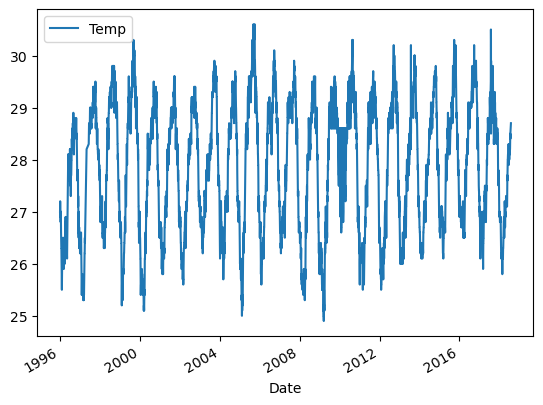

In [82]:
temperature_truncate = temperature.sort_index().truncate(before = '1995-01-01')
# trends = seasonal_decompose(temperature['Temp'], model = 'additive', period = 365)
# trends.plot()
# plt.show()
temperature_truncate.plot()

/var/folders/9t/wltz5rw540dg7_k5xs930j_c0000gn/T/ipykernel_10024/3739817702.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  a_few_days = temperature_truncate[(temperature_truncate.index.date >= start_day) & (temperature_truncate.index.date <= end_day)]


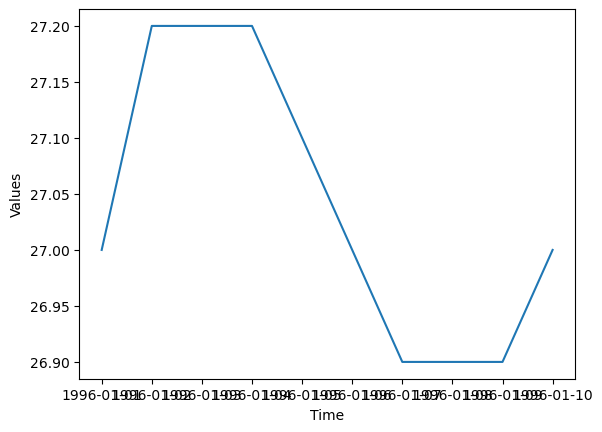

In [95]:
start_day = pd.to_datetime('1996-01-01')
end_day = pd.to_datetime('1996-01-10')

a_few_days = temperature_truncate[(temperature_truncate.index.date >= start_day) & (temperature_truncate.index.date <= end_day)]

# Plot the data
plt.plot(a_few_days.index, a_few_days.values)  # Plotting time against values
plt.xlabel('Time')
plt.ylabel('Values')
#plt.title('Data for {}'.format(start_day, end_day))
plt.show()

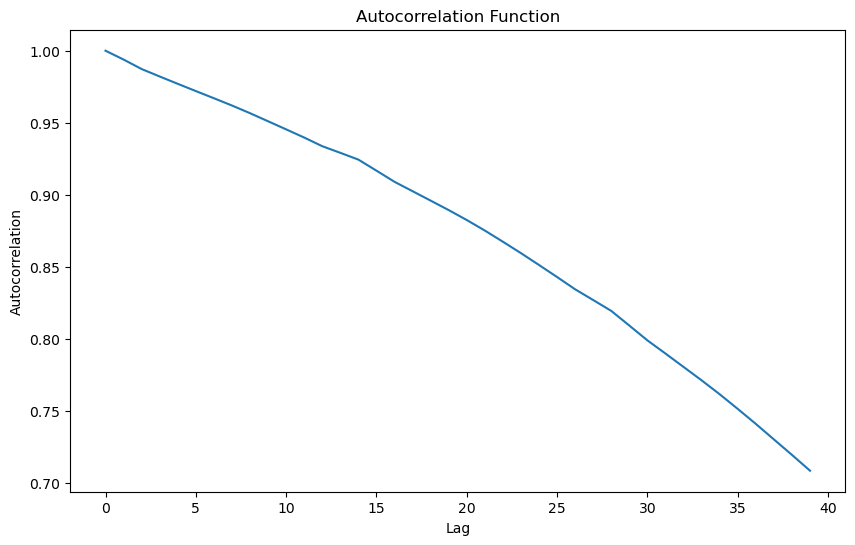

In [114]:
auto_corr = acf(temperature['Temp'])
auto_corr

plt.figure(figsize=(10, 6))
plt.plot(auto_corr)
plt.title('Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()


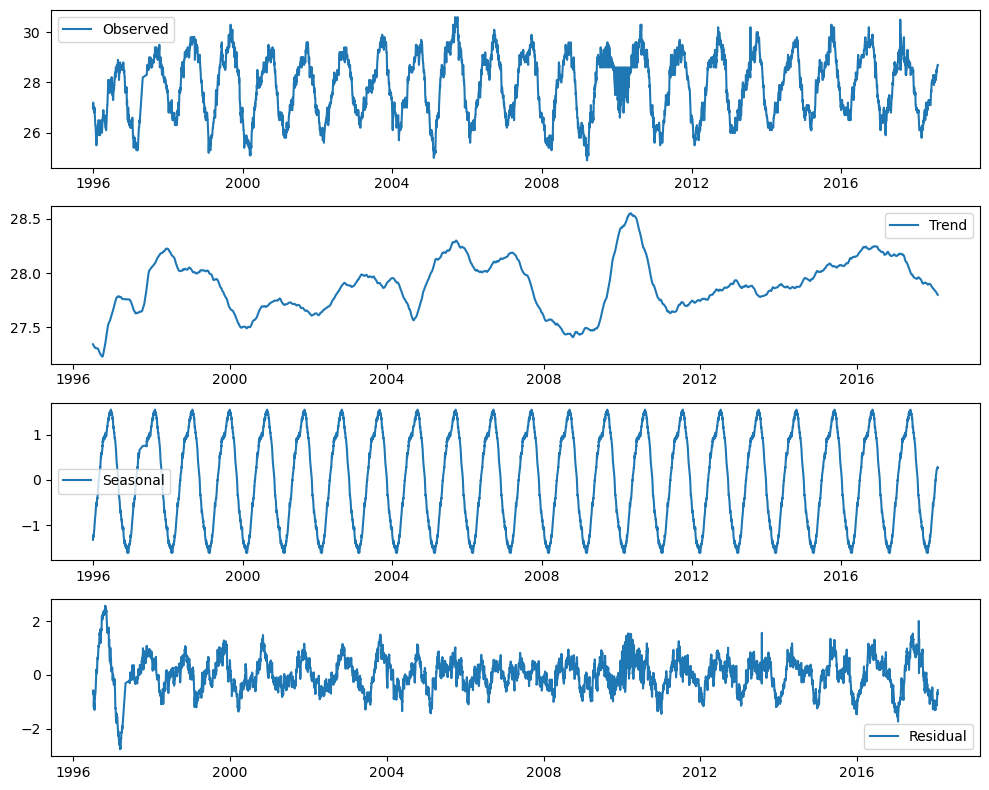

In [158]:
trends = seasonal_decompose(temperature_truncate['Temp'], model = 'additive', period = 365)
# trends.plot()
# plt.show()

# Plot the individual components
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(trends.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(trends.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(trends.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(trends.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

In [118]:
#calculate the moving average
move_average = temperature_truncate.rolling(window = 365).mean()[364:]
move_average

Temp
Date                 
1996-12-30  27.342740
1996-12-31  27.340822
1997-01-01  27.338082
1997-01-02  27.335616
1997-01-03  27.333425
...               ...
2018-07-21  27.803014
2018-07-22  27.801644
2018-07-30  27.800548
2018-07-31  27.799726
2018-08-01  27.798904

[7738 rows x 1 columns]

In [119]:
#calculate the detrended time series
detrend = temperature_truncate[364:] - move_average
detrend

Temp
Date                
1996-12-30 -1.142740
1996-12-31 -1.040822
1997-01-01 -1.138082
1997-01-02 -1.035616
1997-01-03 -0.933425
...              ...
2018-07-21  0.596986
2018-07-22  0.698356
2018-07-30  0.899452
2018-07-31  0.900274
2018-08-01  0.901096

[7738 rows x 1 columns]

In [122]:
#calculate the seasonal component of the time series
season = np.zeros(365) 
for k in range(365):
    season[k] = detrend[k::365].mean()
#extend the period to 365 days
new_season = np.tile(season, len(temperature_truncate[364:])//len(season)+1)[:len(temperature_truncate[364:])]

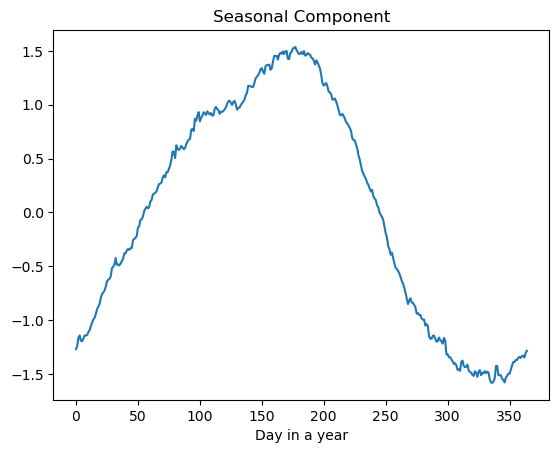

In [124]:
#plot the seasonal component of your time series
plt.plot(season)
plt.xlabel('Day in a year')
plt.title('Seasonal Component')
plt.show()

                Temp
Date                
1996-12-30 -1.142740
1996-12-31 -1.040822
1997-01-01 -1.138082
1997-01-02 -1.035616
1997-01-03 -0.933425
...              ...
2018-07-21  0.596986
2018-07-22  0.698356
2018-07-30  0.899452
2018-07-31  0.900274
2018-08-01  0.901096

[7738 rows x 1 columns]
[-1.26856787 -1.23678705 -1.15951432 ...  0.32646326  0.34429639
  0.32577833]


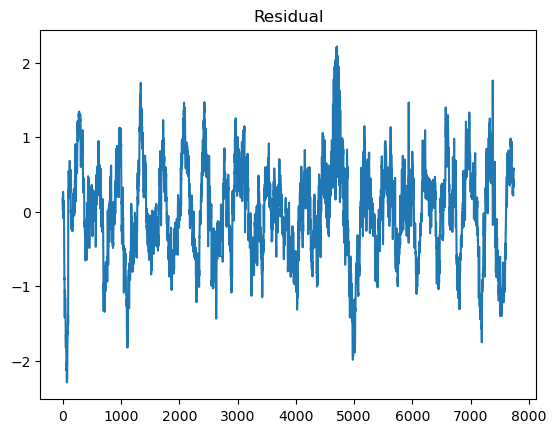

In [132]:
#solve for the time series residual and plot
print(detrend)
print(new_season)
Residual = detrend['Temp'].astype('float') - new_season
plt.plot(np.array(Residual.astype('float')))
plt.title('Residual')
plt.show()

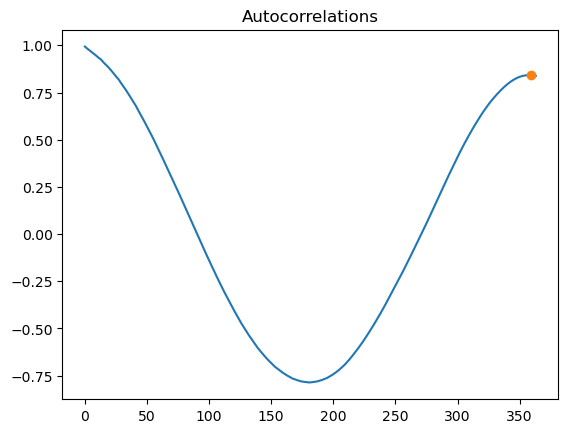

Optimal Periodicity: 359


In [156]:
#plot the autocorrelation of your time series as a function of k
data = [temperature_truncate['Temp'].astype('float').autocorr(lag = k) for k in range(1,365)]
max_index = len(data)//2 +np.argmax(data[len(data)//2:])

plt.plot(data) 
plt.plot(max_index, data[max_index], 'o')
plt.title('Autocorrelations')
plt.show()

print(f'Optimal Periodicity: {max_index}')

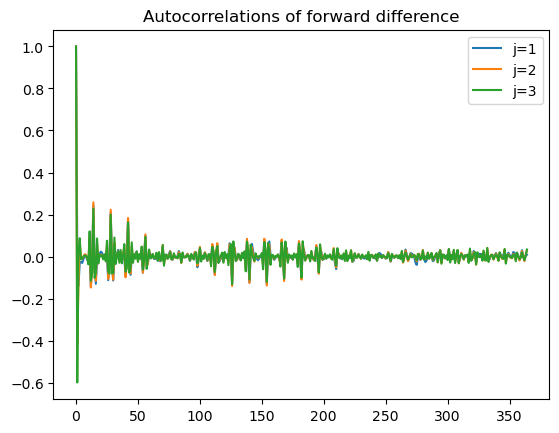

In [138]:
#get the first, second and third order difference quotients
first_diff = Residual.diff(periods = 1)
second_diff = first_diff.diff(periods = 1)
third_diff = second_diff.diff(periods = 1)
#compute the autocorrelation of each time series
auto_cor1 = [first_diff.astype('float').autocorr(lag = k) for k in range(365)] 
auto_cor2 = [second_diff.astype('float').autocorr(lag = k) for k in range(365)] 
auto_cor3 = [third_diff.astype('float').autocorr(lag = k) for k in range(365)]
#plot the autocorrelation
plt.plot(auto_cor1,label = 'j=1')
plt.plot(auto_cor2,label = 'j=2')
plt.plot(auto_cor3,label = 'j=3')
plt.title('Autocorrelations of forward difference')
plt.legend()